/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py", line 217, in _count_physical_cores
    raise ValueError(


💰 Prix unitaire par taille VM (engagement) :
- Large  : 771.51 €
- Medium : 218.35 €
- Small  : 24.30 €
📈 Prix PAYG par taille VM (avec surcharge) :
- Large  : 848.66 €
- Medium : 240.19 €
- Small  : 26.73 €

📊 Synthèse des coûts (par année) :
Année  Usage  Cmin  Cmax  Coût Engagement  Coût PAYG
   Y1    668   534   535         16767.58    3555.66
   Y2    641   512   513         16232.90    3421.99
   Y3    501   400   401         12763.66    2673.43
   Y4    390   331   344          9854.94    1229.78
   Y5    494   419   420         12478.23    1978.34

📁 Export terminé dans 'projection_financiere_complete.csv'


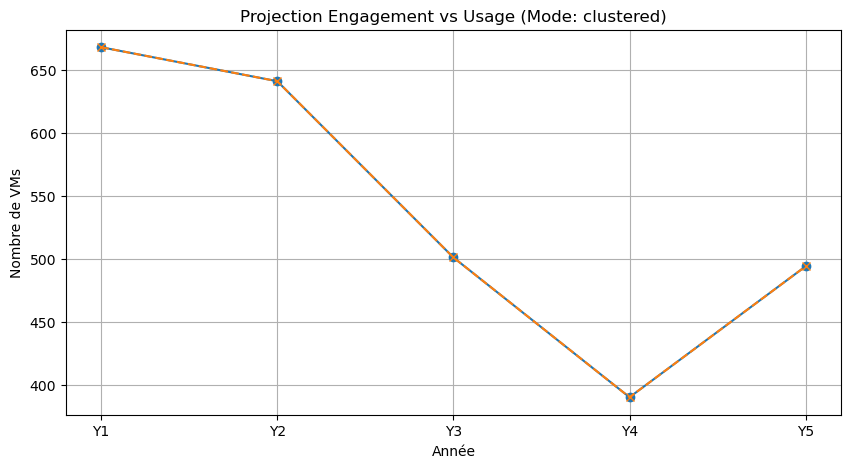

In [2]:
# Not working for Production, under Dev phase
# MODE DE FACTURATION : 'uniform' OU 'clustered'
mode = 'clustered'  # ou 'uniform'
# ==========================================
# CONFIGURATION DES FICHIERS PAR ANNÉE
# ==========================================
# Dictionnaire mapping chaque année contractuelle à son fichier d'export VM
input_files = {
    "Y1": "vm_data_Y1.csv",
    "Y2": "vm_data_Y2.csv",
    "Y3": "vm_data_Y3.csv",
    "Y4": "vm_data_Y4.csv",
    "Y5": "vm_data_Y5.csv",
}

# Engagements financiers
total_contract_value = 100000  # TCV sur 5 ans
annual_engagement_cost = total_contract_value / 5
surcharge_payg = 0.10  # surcharge PAYG (10%)

# Paramètres Cmin et Cmax par année (ratios)
scenario_cmin = {"Y1": 0.80, "Y2": 0.80, "Y3": 0.80, "Y4": 0.85, "Y5": 0.85}
scenario_cmax = {"Y1": 0.80, "Y2": 0.80, "Y3": 0.80, "Y4": 0.88, "Y5": 0.85}

# ==========================================
# 1. Importer les bibliothèques
# ==========================================
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# ==========================================
# 2. Charger et normaliser les données
# ==========================================
df_years = {}
for year, file in input_files.items():
    df = pd.read_csv(file, sep=';')
    # Vérification des colonnes essentielles
    for col in ['VM_ID', 'vCPU', 'RAM_MB', 'Disk_MB']:
        if col not in df.columns:
            raise ValueError(f"Colonne requise manquante dans {file} : {col}")
    # Conversion numérique
    df['RAM_MB']  = df['RAM_MB'].astype(str).str.replace(r'[^0-9]', '', regex=True).astype(int)
    df['vCPU']    = df['vCPU'].astype(str).str.replace(r'[^0-9]', '', regex=True).astype(int)
    df['Disk_MB'] = df['Disk_MB'].astype(str).str.replace(r'[^0-9]', '', regex=True).astype(int)
    # Conversion en unités lisibles
    df['RAM_GB']  = df['RAM_MB']  / 1024
    df['Disk_GB'] = df['Disk_MB'] / 1024
    df_years[year] = df

# ==========================================
# 3. Clustering (si mode clustered)
# ==========================================
if mode == 'clustered':
    base_df = df_years['Y1']
    X_base = base_df[['vCPU', 'RAM_GB', 'Disk_GB']].values
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans.fit(X_base)
    for year, df in df_years.items():
        df['Cluster'] = kmeans.predict(df[['vCPU', 'RAM_GB', 'Disk_GB']].values)

# Mapping clusters vers tailles T-shirt
if mode == 'clustered':
    cluster_summary = (
        pd.concat(df_years.values())
          .groupby('Cluster')
          .agg(
              Count=('VM_ID','count'),
              Avg_vCPU=('vCPU','mean'),
              Avg_RAM_GB=('RAM_GB','mean'),
              Avg_Disk_GB=('Disk_GB','mean')
          )
          .sort_values(['Avg_vCPU','Avg_RAM_GB','Avg_Disk_GB'])
          .reset_index()
    )
    cluster_summary['Tshirt_Size'] = ['Small','Medium','Large']
    for year, df in df_years.items():
        df_years[year] = df.merge(cluster_summary[['Cluster','Tshirt_Size']], on='Cluster', how='left')
else:
    for year, df in df_years.items():
        df['Tshirt_Size'] = 'Standard'

# ==========================================
# 4. Calculs financiers et projections
# ==========================================
export_rows = []
years = list(input_files.keys())

# Helper pour corriger Cmax < Cmin

def adjust_cmax_cmin(cmin, cmax, year):
    if cmax < cmin:
        print(f"⚠️ Attention ({year}) : Cmax ({cmax}) < Cmin ({cmin}), je corrige Cmax = Cmin.")
        return cmin
    return cmax

if mode == 'uniform':
    nb_vm_ref = len(df_years['Y1'])
    prix_commit = annual_engagement_cost / nb_vm_ref
    prix_payg   = prix_commit * (1 + surcharge_payg)
    print(f"💰 Prix unitaire VM (engagement) : {prix_commit:.2f} €")
    print(f"📈 Prix unitaire VM (PAYG)       : {prix_payg:.2f} €")

    for year in years:
        usage = len(df_years[year])
        Cmin = int(np.floor(scenario_cmin[year] * usage))
        Cmax = int(np.ceil (scenario_cmax[year] * usage))
        Cmax = adjust_cmax_cmin(Cmin, Cmax, year)
        vm_engaged = min(usage, Cmax)
        cost_engaged = vm_engaged * prix_commit
        vm_payg = max(0, usage - Cmax)
        cost_payg = vm_payg * prix_payg
        export_rows.append({
            'Année': year,
            'Usage': usage,
            'Cmin': Cmin,
            'Cmax': Cmax,
            'VM Engagées': vm_engaged,
            'Coût Engagement': round(cost_engaged,2),
            'VM PAYG': vm_payg,
            'Coût PAYG': round(cost_payg,2)
        })

else:
    for year, df in df_years.items():
        df['Capacity_Unit'] = df['vCPU'] * df['RAM_GB']
    cap_by_size = df_years['Y1'].groupby('Tshirt_Size')['Capacity_Unit'].sum().to_dict()
    count_by_size = df_years['Y1']['Tshirt_Size'].value_counts().to_dict()
    total_cap = sum(cap_by_size.values())
    base_price = { size: (annual_engagement_cost * cap_by_size[size] / total_cap) / count_by_size[size]
                   for size in cap_by_size }
    print("💰 Prix unitaire par taille VM (engagement) :")
    for size, price in base_price.items():
        print(f"- {size:6} : {price:.2f} €")
    print("📈 Prix PAYG par taille VM (avec surcharge) :")
    for size, price in base_price.items():
        print(f"- {size:6} : {price * (1+surcharge_payg):.2f} €")

    for year in years:
        df = df_years[year]
        usage = len(df)
        Cmin = int(np.floor(scenario_cmin[year] * usage))
        Cmax = int(np.ceil (scenario_cmax[year] * usage))
        Cmax = adjust_cmax_cmin(Cmin, Cmax, year)
        df_sorted = df.sort_values('Capacity_Unit', ascending=False)
        engaged = df_sorted.head(Cmax).copy()
        engaged['Unit_Price'] = engaged['Tshirt_Size'].map(base_price)
        cost_engaged = engaged['Unit_Price'].sum()
        if usage > Cmax:
            payg = df_sorted.tail(usage - Cmax).copy()
            payg['Unit_Price'] = payg['Tshirt_Size'].map(lambda s: base_price[s] * (1 + surcharge_payg))
            cost_payg = payg['Unit_Price'].sum()
        else:
            cost_payg = 0.0
        export_rows.append({
            'Année': year,
            'Usage': usage,
            'Cmin': Cmin,
            'Cmax': Cmax,
            'Coût Engagement': round(cost_engaged,2),
            'Coût PAYG': round(cost_payg,2)
        })

# ==========================================
# 5. Export et visualisation finale
# ==========================================
export_df = pd.DataFrame(export_rows)
print("\n📊 Synthèse des coûts (par année) :")
print(export_df.to_string(index=False))
export_df.to_csv("projection_financiere_complete.csv", sep=';', index=False)
print("\n📁 Export terminé dans 'projection_financiere_complete.csv'")

# Graphique synthèse
plt.figure(figsize=(10,5))
key_curve = 'VM Engagées' if mode=='uniform' else 'Usage'
plt.plot(years, export_df[key_curve], marker='o', linestyle='-')
plt.plot(years, export_df[key_curve], marker='x', linestyle='--')
plt.title(f"Projection Engagement vs Usage (Mode: {mode})")
plt.xlabel('Année')
plt.ylabel('Nombre de VMs')
plt.grid(True)
plt.show()

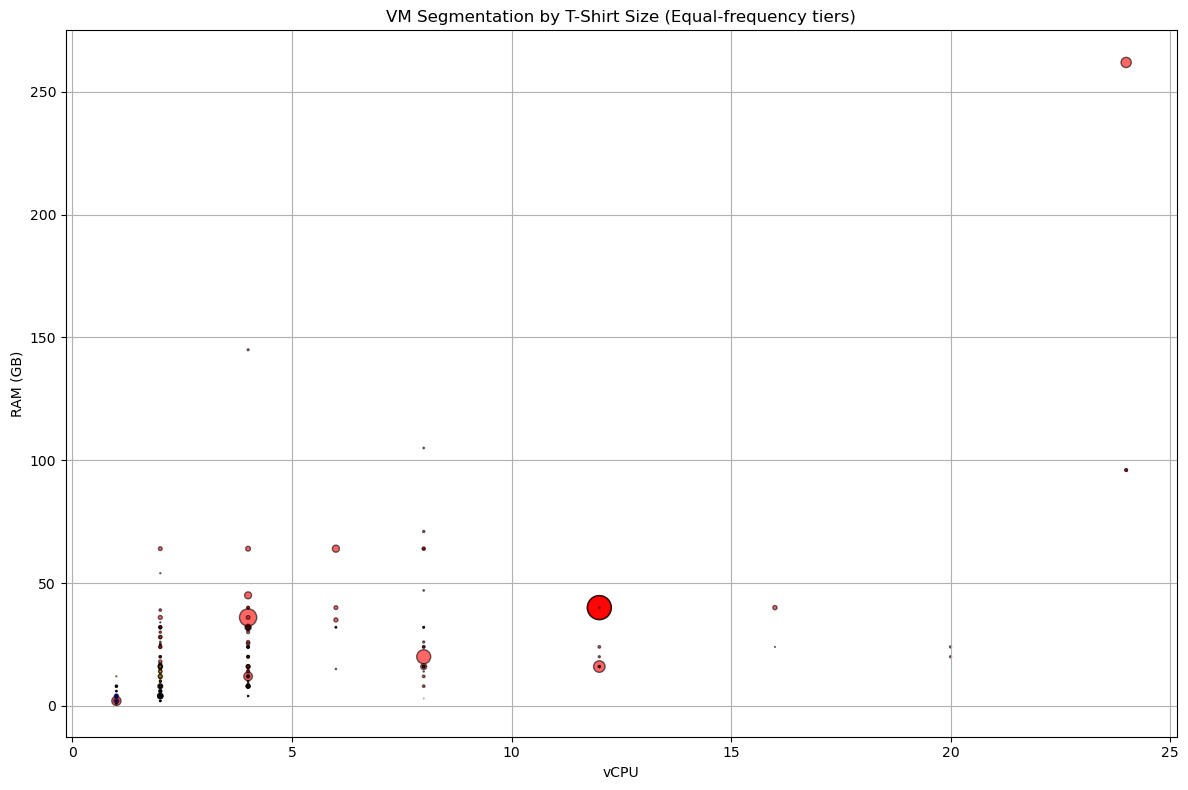

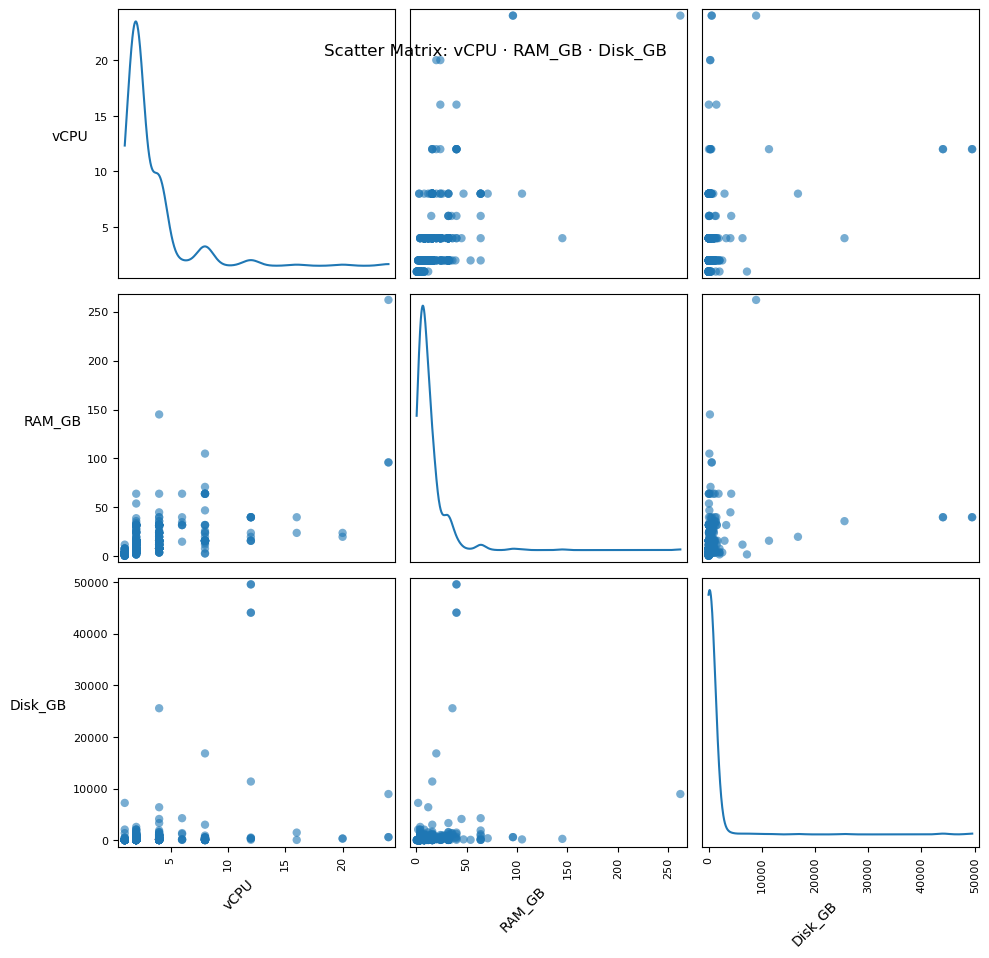

                                    VM_ID  vCPU  RAM_GB  Disk_GB Tshirt_Size
                                           XXXX           2   12.00      293      Medium
                                           XXXX           8   16.00      150       Large
                                           XXXX      1     2    4.00      128       Small
                                           XXXX      2     2    4.00      128       Small
                                           XXXX      1     4   12.00      400       Large
                                           XXXX      POC001     4    8.00      516       Large
                                           XXXX      01     8   16.00     3006       Large
                                           XXXX      POC001     8    8.00      516       Large
                                           XXXX      RD001     2    4.00     2049      Medium
                                           XXXX      RD002     2    4.00     2049      Medium
      

In [25]:
# Author: Anthony Chambet [Solution Architect @ Orange Business] – 2025/05/06
# Under Dev phase.
# Purpose:
# This notebook processes real-world VM inventory data (extracted via RVTools and pre-filtered using a Bash script)
# and applies K-Means clustering to dynamically classify each VM into a T-shirt size category (Small, Medium, Large)
# based on its CPU and RAM allocation.
#
# Objective:
# The goal is to enable a scientific and automated classification mechanism to support dynamic pricing models,
# distinguishing between minimum platform commitments and Pay-As-You-Go (PAYG) excess consumption.
# This approach is relevant in hybrid infrastructure contexts where resources are provisioned as fixed-capacity (CAPEX),
# but usage fluctuates over time. It allows for continuous-time cost modeling without relying on cloud-native elasticity.

# Step 1: Import required libraries
import pandas as pd                        # data manipulation
from sklearn.preprocessing import StandardScaler  # feature scaling
import matplotlib.pyplot as plt            # plotting
from pandas.plotting import scatter_matrix  # scatter matrix

# Step 2: Load data from CSV (semicolon delimiter)
file = 'vm_data.csv'
df = pd.read_csv(file, sep=';')            # read into DataFrame

# Step 3: Ensure essential columns exist
for col in ['VM_ID', 'vCPU', 'RAM_MB', 'Disk_MB']:
    if col not in df.columns:
        raise ValueError(f"Missing required column in {file}: {col}")

# Step 4: Normalize numeric resource fields
# For each metric, strip non-digits and cast to integer
for c in ['vCPU', 'RAM_MB', 'Disk_MB']:
    df[c] = (
        df[c]
        .astype(str)                       # convert any type to string
        .str.replace(r'[^0-9]', '', regex=True)  # remove all non-numeric chars
        .astype(int)                       # convert cleaned strings back to int
    )

# Step 5: Convert to human-readable units
df['RAM_GB']  = (df['RAM_MB']  / 1024).round(2)    # convert MB → GB, keep 2 decimals
df['Disk_GB'] = (df['Disk_MB'] / 1024).round().astype(int)  # convert MB → GB, integer

# Step 6: Drop optional stats columns if present
to_drop = [c for c in ['CPU_avg', 'RAM_avg', 'Uptime_pct'] if c in df.columns]
if to_drop:
    df.drop(columns=to_drop, inplace=True)         # remove unused columns in place

# Step 7: Build composite resource score
features = ['vCPU', 'RAM_MB', 'Disk_MB']
scaler = StandardScaler()                          # initialize standard scaler
X_scaled = scaler.fit_transform(df[features])      # scale each feature
df['ResourceScore'] = X_scaled.sum(axis=1)         # sum scaled features

# Step 8: Assign T-shirt size tiers based on score quantiles
q1, q2 = df['ResourceScore'].quantile([1/3, 2/3])   # compute 33rd and 67th percentiles
df['Tshirt_Size'] = pd.cut(
    df['ResourceScore'],
    bins=[-float('inf'), q1, q2, float('inf')],     # define three bins
    labels=['Small', 'Medium', 'Large']             # label each bin
)

# Step 9: Configure pandas display to show full DataFrame
pd.set_option('display.max_rows',    None)          # no row limit
pd.set_option('display.max_columns', None)          # no column limit
pd.set_option('display.width',       None)          # no width wrapping
pd.set_option('display.max_colwidth', None)         # full cell contents

# Step 10a: Optional 2D scatter plot of vCPU vs RAM, sized by Disk and colored by tier
plt.figure(figsize=(12, 8))
sizes = (df['Disk_GB'] / df['Disk_GB'].max()) * 300
color_map = {'Small': 'blue', 'Medium': 'orange', 'Large': 'red'}
plt.scatter(
    df['vCPU'], df['RAM_GB'],
    s=sizes,
    c=df['Tshirt_Size'].map(color_map),
    alpha=0.6, edgecolors='k'
)
plt.xlabel('vCPU')
plt.ylabel('RAM (GB)')
plt.title('VM Segmentation by T-Shirt Size (Equal-frequency tiers)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 10b: Scatter matrix of vCPU, RAM_GB, Disk_GB
vars_to_plot = ['vCPU', 'RAM_GB', 'Disk_GB']
mat = scatter_matrix(
    df[vars_to_plot],
    figsize=(10, 10),
    diagonal='kde',
    alpha=0.6,
    marker='o',
)
# Beautify axes
for ax in mat.ravel():
    ax.set_xlabel(ax.get_xlabel(), rotation=45, ha='right')
    ax.set_ylabel(ax.get_ylabel(), rotation=0, ha='right')
plt.suptitle('Scatter Matrix: vCPU · RAM_GB · Disk_GB', y=0.92)
plt.tight_layout()
plt.show()

# Step 11: Print final table of VM_ID, resources and assigned size
print(
    df[['VM_ID', 'vCPU', 'RAM_GB', 'Disk_GB', 'Tshirt_Size']]
    .to_string(index=False)
)

# Step 12: Export sorted CSV for easy download
# — sort by Tshirt_Size (Small → Medium → Large) and then by ResourceScore desc within each
size_order = ['Small','Medium','Large']
df['Tshirt_Size'] = pd.Categorical(df['Tshirt_Size'], categories=size_order, ordered=True)
df_sorted = df.sort_values(['Tshirt_Size','ResourceScore'], ascending=[True, False])

# select just the columns you care about
output_cols = ['VM_ID', 'vCPU', 'RAM_GB', 'Disk_GB', 'Tshirt_Size']
df_sorted[output_cols].to_csv('vm_clustered_sorted.csv', sep=';', index=False)
print("Exported clustered VM list to vm_clustered_sorted.csv")

In [3]:
# --- Step 6: Multi-Year Business Case --------------------------------------
# Pricing parameters
contract_years   = 3
sizes            = ['Small','Medium','Large']
annual_price     = {'Small':40*12, 'Medium':90*12, 'Large':170*12}
reserved_discount= 0.10    # 10% discount on reserved capacity
paygo_markup     = 0.25    # 25% surcharge for paygo
# Commitment profile by contract year
commit_pct       = {1:1.00, 2:0.90, 3:0.70, 4:0.80, 5:0.90} #expected workload increase with new projects

# Build lookup from cluster index → T-shirt size
cluster_to_size = dict(zip(cluster_summary['Cluster'], cluster_summary['Tshirt_Size']))

# Define contract-year snapshots
years = list(range(1, contract_years+1))
files = { y: f'vm_snapshot_{y}.csv' for y in years }

# Collect actual usage per year
real_usage_by_year = {}
for year in years:
    df_yr = pd.read_csv(files[year], sep=';')
    # Clean vCPU
    df_yr['vCPU'] = (
        df_yr['vCPU'].astype(str)
                     .str.replace(r'[^0-9]', '', regex=True)
                     .astype(int)
    )
    # Recompute MB features from GB if needed
    if 'RAM_GB' in df_yr.columns:
        df_yr['RAM_MB'] = (df_yr['RAM_GB']*1024).astype(int)
    if 'Disk_GB' in df_yr.columns:
        df_yr['Disk_MB']= (df_yr['Disk_GB']*1024).astype(int)
    # Assign clusters & sizes
    Xsc = scaler.transform(df_yr[['vCPU','RAM_MB','Disk_MB']])
    df_yr['Cluster']     = kmeans.predict(Xsc)
    df_yr['Tshirt_Size'] = df_yr['Cluster'].map(cluster_to_size)
    # Count VMs by size
    counts = df_yr['Tshirt_Size'].value_counts().to_dict()
    real_usage_by_year[year] = { size: counts.get(size,0) for size in sizes }

#-----------------------------------------------------------------------------#
# --- Step 6b: Comprehensive Multi-Year Business Case -----------------------

# Build a more detailed business-case table with extra metrics:
#  • Committed Count      → how many VMs are reserved
#  • Reserved Monthly €/an→ monthly prepayment amount
#  • PayGo Monthly €/an   → monthly pay-as-you-go forecast amount
#  • Variance (VMs)       → difference between actual and reserved counts
#  • Year-End Adjustment  → money to refund or bill at year-end
#  • Net Annual Billing   → reserved prepayment plus/minus adjustment
#  • Net Monthly Billing  → net annual billing ÷ 12

records = []
for year in years:
    # % of forecast the customer commits this contract year
    commit_frac = commit_pct[year]

    for size in sizes:
        # 1) Actual average monthly VMs of this size
        n_real = real_usage_by_year[year][size]

        # 2) Base list price per VM per year
        list_price = annual_price[size]

        # 3) Compute how many VMs are actually reserved
        committed_count = commit_frac * n_real

        # 4) Reserved (committed) cost at discounted rate
        #    applied to the committed_count
        reserved_annual  = list_price * committed_count * (1 - reserved_discount)
        reserved_monthly = reserved_annual / 12

        # 5) Pay-as-you-go cost on that same reserved volume at markup
        paygo_annual  = list_price * committed_count * (1 + paygo_markup)
        paygo_monthly = paygo_annual / 12

        # 6) Variance between actual usage and reserved commitment
        variance = n_real - committed_count

        # 7) Year-end adjustment:
        #    • Positive variance → extra consumption billed at paygo rate
        #    • Negative variance → refund at reserved discount rate
        if variance > 0:
            adjustment = variance * list_price * (1 + paygo_markup)
        else:
            adjustment = variance * list_price * (1 - reserved_discount)

        # 8) Net billing = prepaid reserved cost + adjustment
        net_annual  = reserved_annual + adjustment
        net_monthly = net_annual / 12

        # 9) Append all metrics to records
        records.append({
            'Contract Year':           year,
            'Tshirt_Size':             size,
            'Real Avg VMs':            n_real,
            'Commitment %':            f"{commit_frac:.0%}",
            'Committed Count':         round(committed_count, 2),
            'Reserved Annual (€)':     round(reserved_annual, 2),
            'Reserved Monthly (€)':    round(reserved_monthly, 2),
            'PayGo Annual (€)':        round(paygo_annual, 2),
            'PayGo Monthly (€)':       round(paygo_monthly, 2),
            'Variance (VMs)':          round(variance, 2),
            'Year-End Adjustment (€)': round(adjustment, 2),
            'Net Annual Billing (€)':  round(net_annual, 2),
            'Net Monthly Billing (€)': round(net_monthly, 2),
        })

# Convert to DataFrame, display and export
bc_df = pd.DataFrame(records)
display(bc_df)

# Export to CSV for client reporting
bc_df.to_csv('business_case_comprehensive.csv', sep=';', index=False)
print("✅ Exported 'business_case_comprehensive.csv' with detailed billing metrics")

NameError: name 'scaler' is not defined


--- VM Inventory Analysis ---
Total number of VMs: 668
Total vCPUs used: 2043
Total RAM used (GB): 8770.72
Total Disk used (GB): 442142

VM Count by T-shirt Size:
Tshirt_Size
Small     223
Medium    223
Large     222
Name: count, dtype: int64

--- Derived Flex Capacity Parameters ---
Committed Capacity (vCPU): 2043
Buffer Capacity (vCPU): 408
Elastic Capacity (vCPU): 204
Committed RAM (GB): 8770
Buffer RAM (GB): 1754
Elastic RAM (GB): 877

--- Pricing Model for Compute & Memory Capacity ---
Committed: 20 €/vCPU/month, 5 €/GB/month
Buffer: 0.06 €/vCPU/hour, 0.01 €/GB/hour
Elastic: 0.12 €/vCPU/hour, 0.02 €/GB/hour

--- Expected Monthly Usage Profile (vCPU / RAM) ---
Month M1: 1634 vCPU / 7016 GB RAM
Month M2: 1940 vCPU / 8331 GB RAM
Month M3: 2247 vCPU / 9647 GB RAM
Month M4: 2655 vCPU / 11401 GB RAM
Month M5: 1838 vCPU / 7893 GB RAM

Flex-style monthly billing simulation (CPU + RAM Committed, Buffer, Elastic):

  Month  Usage_vCPU  Usage_RAM_GB  Cost_Committed_CPU (€)  \
0    M1       

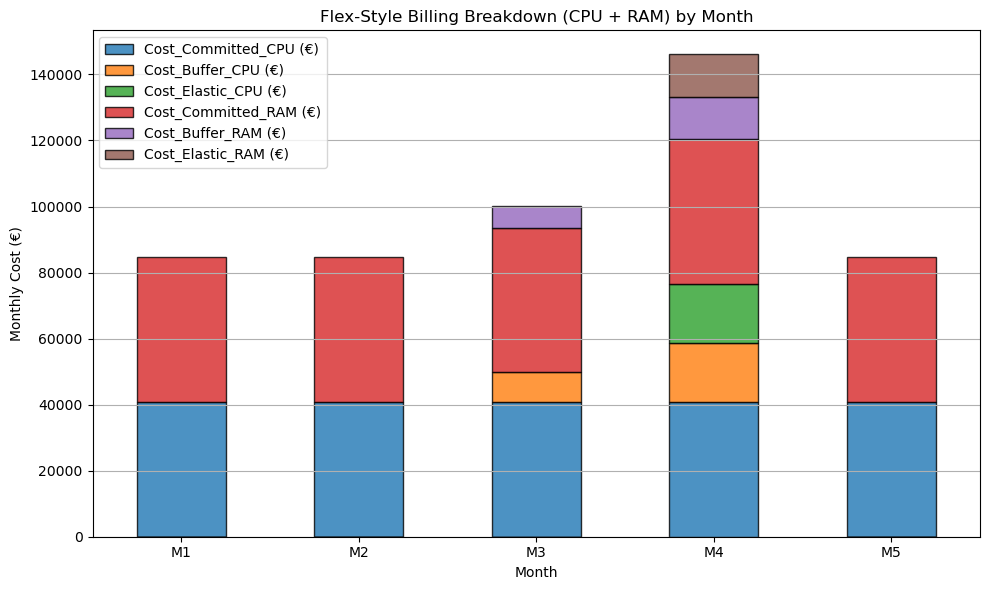

In [4]:
# Step 17: Flex-Style Billing Simulation Based on Deployed Capacity

import matplotlib.pyplot as plt
import pandas as pd

# Load clustered VM data from previous T-shirt sizing output
vm_file = 'vm_clustered_sorted.csv'
df_vm = pd.read_csv(vm_file, sep=';', names=['VM_ID', 'vCPU', 'RAM_GB', 'Disk_GB', 'Tshirt_Size'], header=0)

# Step 18: Analyze VM Inventory State of the Art
print("\n--- VM Inventory Analysis ---")
print(f"Total number of VMs: {len(df_vm)}")
print(f"Total vCPUs used: {df_vm['vCPU'].sum()}")
print(f"Total RAM used (GB): {df_vm['RAM_GB'].sum():.2f}")
print(f"Total Disk used (GB): {df_vm['Disk_GB'].sum()}")
print("\nVM Count by T-shirt Size:")
print(df_vm['Tshirt_Size'].value_counts())

# Step 19: Simulation Parameters (centralized definition)

# Usage multipliers per month (used to simulate load fluctuations)
usage_multipliers = [0.8, 0.95, 1.1, 1.3, 0.9]  # applied to both vCPU and RAM

# Flex Capacity Ratios
buffer_ratio = 0.2
elastic_ratio = 0.1

# Pricing Model
price_committed = 20      # €/vCPU/month
price_buffer = 0.06       # €/vCPU/hour
price_elastic = 0.12      # €/vCPU/hour

price_ram_committed = 5   # €/GB/month
price_ram_buffer = 0.01   # €/GB/hour
price_ram_elastic = 0.02  # €/GB/hour

# Assume average number of hours in a month
hours_per_month = 730

# Step 20: Derived Capacity from Inventory State

total_vcpu = df_vm['vCPU'].sum()
total_ram = df_vm['RAM_GB'].sum()

df_flex_billing = pd.DataFrame()

committed_capacity = int(total_vcpu)
buffer_capacity = int(committed_capacity * buffer_ratio)
elastic_capacity = int(committed_capacity * elastic_ratio)

committed_ram = int(total_ram)
buffer_ram = int(committed_ram * buffer_ratio)
elastic_ram = int(committed_ram * elastic_ratio)

print("\n--- Derived Flex Capacity Parameters ---")
print(f"Committed Capacity (vCPU): {committed_capacity}")
print(f"Buffer Capacity (vCPU): {buffer_capacity}")
print(f"Elastic Capacity (vCPU): {elastic_capacity}")
print(f"Committed RAM (GB): {committed_ram}")
print(f"Buffer RAM (GB): {buffer_ram}")
print(f"Elastic RAM (GB): {elastic_ram}")

print("\n--- Pricing Model for Compute & Memory Capacity ---")
print(f"Committed: {price_committed} €/vCPU/month, {price_ram_committed} €/GB/month")
print(f"Buffer: {price_buffer} €/vCPU/hour, {price_ram_buffer} €/GB/hour")
print(f"Elastic: {price_elastic} €/vCPU/hour, {price_ram_elastic} €/GB/hour")

# Step 21: Simulated Monthly Usage
usage_profile_vcpu = [int(committed_capacity * x) for x in usage_multipliers]
usage_profile_ram = [int(committed_ram * x) for x in usage_multipliers]

print("\n--- Expected Monthly Usage Profile (vCPU / RAM) ---")
for i, (cpu, ram) in enumerate(zip(usage_profile_vcpu, usage_profile_ram), start=1):
    print(f"Month M{i}: {cpu} vCPU / {ram} GB RAM")

# Step 22: Billing Computation
billing_results = []

for month, (cpu_usage, ram_usage) in enumerate(zip(usage_profile_vcpu, usage_profile_ram), start=1):
    committed_cpu = min(cpu_usage, committed_capacity)
    buffer_cpu = min(max(cpu_usage - committed_capacity, 0), buffer_capacity)
    elastic_cpu = max(cpu_usage - committed_capacity - buffer_capacity, 0)

    committed_ram_use = min(ram_usage, committed_ram)
    buffer_ram_use = min(max(ram_usage - committed_ram, 0), buffer_ram)
    elastic_ram_use = max(ram_usage - committed_ram - buffer_ram, 0)

    cost_committed_cpu = committed_capacity * price_committed
    cost_buffer_cpu = buffer_cpu * price_buffer * hours_per_month
    cost_elastic_cpu = elastic_cpu * price_elastic * hours_per_month

    cost_committed_ram = committed_ram * price_ram_committed
    cost_buffer_ram = buffer_ram_use * price_ram_buffer * hours_per_month
    cost_elastic_ram = elastic_ram_use * price_ram_elastic * hours_per_month

    total_cost = sum([cost_committed_cpu, cost_buffer_cpu, cost_elastic_cpu,
                      cost_committed_ram, cost_buffer_ram, cost_elastic_ram])

    billing_results.append({
        'Month': f'M{month}',
        'Usage_vCPU': cpu_usage,
        'Usage_RAM_GB': ram_usage,
        'Cost_Committed_CPU (€)': round(cost_committed_cpu, 2),
        'Cost_Buffer_CPU (€)': round(cost_buffer_cpu, 2),
        'Cost_Elastic_CPU (€)': round(cost_elastic_cpu, 2),
        'Cost_Committed_RAM (€)': round(cost_committed_ram, 2),
        'Cost_Buffer_RAM (€)': round(cost_buffer_ram, 2),
        'Cost_Elastic_RAM (€)': round(cost_elastic_ram, 2),
        'Total_Cost (€)': round(total_cost, 2)
    })

# Final output
print("\nFlex-style monthly billing simulation (CPU + RAM Committed, Buffer, Elastic):\n")
df_flex_billing = pd.DataFrame(billing_results)
print(df_flex_billing)

# Export to CSV
df_flex_billing.to_csv("flex_billing_simulation.csv", sep=";", index=False)
print("\nExported flex-style billing simulation to flex_billing_simulation.csv")

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
df_flex_billing.set_index('Month')[['Cost_Committed_CPU (€)', 'Cost_Buffer_CPU (€)', 'Cost_Elastic_CPU (€)',
                                   'Cost_Committed_RAM (€)', 'Cost_Buffer_RAM (€)', 'Cost_Elastic_RAM (€)']].plot(
    kind='bar', stacked=True, ax=ax, alpha=0.8, edgecolor='black'
)
plt.ylabel("Monthly Cost (€)")
plt.title("Flex-Style Billing Breakdown (CPU + RAM) by Month")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()